시각화 참고: https://neptune.ai/blog/plotly-python-tutorial-for-machine-learning-specialists


In [ ]:
import pandas as pd
!pip install datatable  #엑셀 파일 및 대용량 데이터를 가져오기 위해 필요한 datatable 모듈을 설치합니다
import datatable as dt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96.9 MB 123 kB/s 


##step1: 상위카테고리 딕셔너리 생성

1. 파일열기

In [ ]:
#카테고리 파일 불러오기
category_df = pd.read_csv('/content/drive/MyDrive/review_data_20220316/dogpre.gd_category_202203161107.csv',encoding='utf-8')

#상품번호 및 카테고리 파일(dogpre.gd_goods_link_202203161106) 불러오기
goods_link_df = pd.read_csv('/content/drive/MyDrive/review_data_20220316/dogpre.gd_goods_link_202203161106.csv',encoding='utf-8')

#상품번호 및 실제 리뷰 파일(dogpre.gd_goods_review_202203160949) 불러오기
datatable_df = dt.fread('/content/drive/MyDrive/review_data_20220316/dogpre.gd_goods_review_202203160949.csv',encoding='utf-8')
goods_review_df = datatable_df.to_pandas()

In [ ]:
#모든 카테고리 추출
#wholecate_dic = category_df.set_index('category').T.to_dict('list')
#print(wholecate_dic)

In [ ]:
#모든 카테고리 걔수 확인
len(category_df)

127

2. 상위카테고리(‘category’ 값이 100이하인 경우 상위카테고리) 추출 후 ‘category’의 값을 key로 하고 이 외의 열의 값들을 value로 하는 딕셔너리 생성

In [ ]:
#상위 카테고리 20개 추출(상위 카테고리 번호는 두자리--> 하위 카테고리는 상위카테고리*1000대의 숫자)
super_category = category_df[category_df['category']<100]

supcate_dic = super_category.set_index('category').T.to_dict('list') #카테고리 코드를 key로 하고 다른 변수들로 이루어진 리스트를 value로 갖는 딕셔너리 생성
supcate_dic[0]=[None, '분류안됨'] #유효하지 않은 하위 카테고리에 부여될 상위 카테고리 0 생성

supcate_dic #딕셔너리 출력 결과: key는 상위카테고리 코드, value[1]은 상위카테고리 이름이 됨

{0: [None, '분류안됨'],
 16: [128, '사은품', 15, 1, 0, nan, 0, nan, nan, 0],
 36: [364,
  '사료',
  0,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/036.png',
  0,
  nan,
  nan,
  0],
 37: [370, '치아', 16, 1, 0, nan, 0, nan, nan, 0],
 38: [377,
  '건강관리',
  3,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/038.png',
  0,
  nan,
  nan,
  0],
 39: [386,
  '위생/배변',
  4,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/039.png',
  0,
  nan,
  nan,
  0],
 40: [391,
  '미용/목욕',
  5,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/040.png',
  0,
  nan,
  nan,
  0],
 41: [401,
  '급식기/급수기',
  6,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/041.png',
  0,
  nan,
  nan,
  0],
 42: [410,
  '하우스/울타리',
  7,
  0,
  1,
  'https://dogpre-upload.s3.ap-northeast-2.amazonaws.com/web/category/042.png',
  0,
  nan,
  nan,
  0],
 43: [417,
  '이동장',
  8,
  0,

In [ ]:
#상위 카테고리 개수 확인
len(supcate_dic)

21

##step2: 전체 상품의 하위 카테고리를 상위 카테고리로 재분류

1. 중복 상품번호 제거

In [ ]:
#상품 번호가 중복되는 경우 확인: 15449개
a = goods_link_df[goods_link_df.duplicated(['goodsno'])]#.sum()
len(a)
#b = a[a['supcate']==0] #상품번호가 중복이고 카테고리가 분류되지 않은 경우: 15394
#c = a[a['supcate']!=0] #상품번호가 중복이고 카테고리가 분류된 경우: 55
#print(len(b))
#c

15449

In [ ]:
goods_link_df=goods_link_df.drop_duplicates(['goodsno']) #상품번호 중복일 경우 데이터 제거
goods_link_df

,sno,goodsno,category,sort,hidden
0,4,4,1001,-1185200690,1
1,9,9,1001,-1185200694,1
2,11,11,1001,-1185200695,1
3,15,15,1002,0,1
4,18,18,1002,0,1
...,...,...,...,...,...
67598,170566,88175,39002,0,0
67599,170570,88266,40006,0,0
67600,170573,88241,51003,0,0
67601,170572,88230,38004,0,0


2. 상품의 상위카테고리 열의 값을 0으로 초기화하고 하위카테고리와 상위카테고리 딕셔너리에 따라 값을 수정

In [ ]:
#모든 상품의 카테고리 분포 보기
'''
전체 카테고리는 123개 항목으로 이루어져 있으므로, 상품을 분류하는 기준으로 사용하기에는 너무 많아 적합하지 않다고 판단
=> 전체 카테고리 대신 상위 카테고리 21개 항목(sipcate_dic에 정의되어 있음)으로 분류를 시행하기로 결정
'''

#하위 카테고리를 모두 상위 카테고리로 재분류
goods_link_df['supcate']=0 #상위 카테고리 column을 생성하고 모든 값을 0으로 초기화

for i in supcate_dic: #모든 상위 카테고리 코드에 대하여 반복
  #상품의 카테고리가 상위 카테고리 그 자체일 경우: 현재 카테고리를 supcate열의 값에 할당
  goods_link_df.loc[goods_link_df['category']==i,'supcate'] = i 
  #상품의 카테고리가 상위 카테고리에 속하는 하위 카테고리일 경우: 상위 카테고리를 supcate열의 값에 할당
  goods_link_df.loc[(goods_link_df['category']>=i*1000) & (goods_link_df['category']<(i+1)*1000),'supcate'] = i 
  
goods_link_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,sno,goodsno,category,sort,hidden,supcate
0,4,4,1001,-1185200690,1,0
1,9,9,1001,-1185200694,1,0
2,11,11,1001,-1185200695,1,0
3,15,15,1002,0,1,0
4,18,18,1002,0,1,0
...,...,...,...,...,...,...
67598,170566,88175,39002,0,0,39
67599,170570,88266,40006,0,0,40
67600,170573,88241,51003,0,0,51
67601,170572,88230,38004,0,0,38


##step3: 전체 상품의 카테고리 비율을 나타낸 파이 차트 생성

1. 각 상위 카테고리 당 상품 개수를 pandas series 또는 딕셔너리 자료형으로 나타냄

In [ ]:
#상위 카테고리에 해당하는 상품 개수 카운트하기
cate_counting = goods_link_df['supcate'].value_counts() #모든 상품의 상위 카테고리 값과 그 개수를 pandas series 자료형으로 반환
'''
supcate_dic에 저장된 상위 카테고리 코드는 21개 항목이지만 실제 상품이 사용된 항목은 15개임을 확인
상품 중 카테고리가 분류되지 못한 경우가 38.9%로 가장 많았음
'''
cate_counting

0     20272
44    11243
51     4344
45     3613
36     2891
42     2710
47     1193
40     1168
43      997
41      881
16      839
39      835
38      826
58      163
48      107
37       72
Name: supcate, dtype: int64

2. 파이차트 생성(전체 상품의 상위 카테고리 비율)

In [ ]:
#모든 상품의 카테고리를 분류한 결과를 파이차트로 시각화하여 카테고리 별 비율 확인
import plotly.express as px
import plotly.graph_objects as go

labels = [supcate_dic[i][1] for i in cate_counting.index] #카테고리 코드의 이름을 label로 받음
values = cate_counting.values #카테고리 코드 별 빈도수를 value로 받음

fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, hole=0.2)]) #전체 상품 카테고리 비율 파이 차트 생성: 위에서 설정해둔 labels와 values를 가지며, 중앙 여백의 원 반지름을 0.2로 설정

fig.update_layout(title_text=f"<b>전체 상품({len(goods_link_df)}개) 카테고리 비율(중복제거)</b>") #파이차트 제목
#fig.write_image("/content/drive/MyDrive/review_data_20220316/전체상품카테고리비율(중복제거).png")
fig.show() #파이차트 출력

##step 4: 전체 후기의 카테고리 비율을 나타낸 파이 차트 생성

In [ ]:
#전체 후기 개수 확인
len(goods_review_df)

4490421

1. 상품번호를 key로 왼쪽 외부 조인하여 후기 데이터프레임에 카테고리 정보 추가하고 카테고리 정보를 추가할 수 없을 경우 상위카테고리를 0으로 설정

In [ ]:
'''
전체 후기가 어떤 카테고리에 속하는 상품에 대한 후기인지를 분류하기 위하여
전체 후기 데이터프레임의 상품번호와 상품번호-카테고리 연결 데이터프레임의 상품번호를 왼쪽 외부조인 함.
'''

#전체 후기 데이터프레임과 상품번호-카테고리 연결 데이터프레임을 상품번호를 key로 왼쪽 외부조인
review_cate = pd.merge(goods_review_df, goods_link_df, left_on='goodsno', right_on='goodsno', how='left')

In [ ]:
#전체 후기에 대하여 어떤 카테고리에 속하는 상품에 대한 후기인지 분류한 결과 출력
review_cate 

,goodsno,subject,contents,point,category,supcate
0,37634,강아지들이 좋아라해요!~,이거 병원에서 1000원이던데~!\r\n 이게 원래는 사료라던데!~? 강쥐들이 죠아...,5.0,51003.0,51.0
1,37634,완전싸네요!!~,이거 집 앞 슈퍼에서 750원에 팝니당~\r\n양이 더 많을줄 알았는데 같네요\r\...,5.0,51003.0,51.0
2,37634,미끼용으로 좋습니다!! 추천!,사료줄때 ...몇개 넣어서주면 좋아요 ~^^...그래서 이번에 구매할때 이고 살려구...,5.0,51003.0,51.0
3,37634,잘먹습니다^-^,간식도 같은거 먹으면 금새 싫증내는데\r\n이건 물리지 않는지 잘먹어여,5.0,51003.0,51.0
4,2066,자주 간식을 줘야한다면 추천 ^^,우리강쥐는간식을항상줘야말을들어서 간식감당을못했거든요 \r\n근데 50p나되니 하루에...,5.0,51008.0,51.0
...,...,...,...,...,...,...
4490416,19139,아주 좋아해요,환장하고 먹어요 진짜 좋아해요,5.0,51008.0,51.0
4490417,57301,잘먹어요,너무 잘먹어서 자주 시켜요,5.0,51002.0,51.0
4490418,19142,아주 좋아해요,넘나 좋아해요 1등이에요,5.0,51002.0,51.0
4490419,46856,잘먹어요,유산균 함유된 스틱이라고 해서 주문해 봤고..\n딱딱하지 않아서 좋아요..\n멍이도...,5.0,51002.0,51.0


2. 각 상위 카테고리 당 후기 개수를 pandas series 또는 딕셔너리 자료형으로 나타냄

In [ ]:
#카테고리가 분류되지 못한 후기의 상위 카테고리(supcate)를 0으로 설정
review_cate.loc[review_cate['supcate'].isnull(),'supcate']=0 

In [ ]:
#상위 카테고리에 해당하는 후기 개수 카운트하기
rcate_counting = review_cate['supcate'].value_counts() #후기 데이터프레임에서 사용된 상위카테고리 코드와 그 개수를 pandas series 자료형으로 반환
rcate_counting #상위 카테고리 사용 횟수 출력

51.0    1842277
0.0      592539
36.0     402884
39.0     359292
47.0     312004
38.0     289902
40.0     271309
41.0     139832
45.0      90856
42.0      74694
44.0      68198
37.0      11459
43.0      11445
48.0       9970
58.0       7802
16.0       5958
Name: supcate, dtype: int64

3. 파이차트 생성(전체 후기의 상위 카테고리 비율)

In [ ]:
#전체 후기 카테고리 비율

labels = [supcate_dic[i][1] for i in rcate_counting.index] #후기 데이터프레임에서 사용된 상위 카테고리 코드의 이름을 labels에 넣어줌
values = rcate_counting.values #후기 데이터프레임에서 사용된 상위 카테고리 코드의 개수를 values에 넣어줌

fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, hole=0.2)]) #전체 후기 카테고리 비율 파이차트 생성: 위에서 설정해둔 labels와 values를 가지며, 중앙 여백의 원 반지름을 0.2로 설정
    
fig.update_layout(title_text=f"<b>전체 후기({len(review_cate)}개) 카테고리 비율(중복제거)</b>") #파이 차트 제목 생성
#plotly.offline.plot(fig,filename="/content/drive/MyDrive/review_data_20220316/전체후기카테고리비율(중복제거).html")
fig.show() #파이차트 출력

##step 5: 평점별 워드크라우드 생성

1. 모든 후기에서 명사만을 추출하는 전처리를 위한 라이브러리 불러오기

In [ ]:
#한글 전처리 모델을 위한 셀
#한국어 NLP를 위한 ennjeon 라이브러리 설치합니다.
!pip install  konlpy
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
from konlpy.tag import Mecab
m = Mecab()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 84.3 MB/s 
     |████████████████████████████████| 453 kB 56.0 MB/s 
Installing automake (A dependency for mecab-ko)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security/rest

2. 모든 후기에서 한글만을 추출하는 전처리를 위한 함수 정의

In [ ]:
#후기 데이터프레임(review_cate) 전처리
import numpy as np
import re

def kextract(s):  #후기에서 한글만 뽑아 전처리하는 함수 작성
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')  #후기에서 한글이 아닌 문자만 추출
  result = hangul.sub(' ',str(s)) #한글이 아닌 문자일 경우 공백으로 대체
  return result

#함수 확인
kextract('강아지가 클때까지 먹이려고 큰거 샀는데..\r\n다른 쇼핑몰 보다 싸서 좋네요~\r...😂')

'강아지가 클때까지 먹이려고 큰거 샀는데 다른 쇼핑몰 보다 싸서 좋네요 '

In [ ]:
#후기의 제목과 본문에서 한글만 추출
review_cate['contents'] = [kextract(s) for s in review_cate['contents']]
review_cate['subject'] = [kextract(s) for s in review_cate['subject']]
review_cate = review_cate.dropna(subset=['contents'], axis=0).reset_index(drop=True) #후기 내용이 NULL값인 행 제거

review_cate.isnull().sum()  #null값이 있는 열 확인

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



subject     0
contents    0
point       0
supcate     0
dtype: int64

3. 워드클라우드 생성을 위한 모듈 및 한글 폰트 설치

In [ ]:
#평점별 워드 크라우드 생성을 위한 모듈 설치 및 불러오기
!pip install wordcloud
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#워드클라우드 생성을 위한 한글폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
sys_font = fm.findSystemFonts()

{f for f in sys_font if 'Nanum' in f}

Selecting previously unselected package fonts-nanum.
(Reading database ... 155924 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


{'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/

4. 워드클라우드 생성

In [ ]:
#평점 별 빈도수 상위 100개 단어 추출하여 워드클라우드 생성

for i in range(5,0,-1):
  current_point = review_cate[review_cate['point']==i] #review_cate(전처리된 후기 데이터프레임)에서 평점이 i인 데이터만 추출
  subject_list = current_point['subject'].tolist() #제목만 리스트로
  content_list = current_point['contents'].tolist() #내용만 리스트로

  #후기들에 등장하는 단어들의 빈도수 확인을 위해 명사 추출
  dataset = []
  stopwords = ['구매','거','것','때','번','아이','중',
              '수','생각','데','강','쥐','이거','게','애','저희','듯',
              '후','전','요향','맘','건','제','나','이건','년','저','대통령','우리','이',
              '만','이번','편','건데','이걸로','편','개','다음','애기','집','견','내','강아지','이것','시','후기']  
              #우리: 소유격, 개: 진돗개라는 반복적인 리뷰에만 등장하는 단어, 집: '우리집 강아지'같은 단어에서 사용
              #강아지: 사용되는 빈도수가 너무 높아 제외

  for r in range(len(current_point)):
    tmp = subject_list[r]+' '+content_list[r] #한 개의 후기의 제목과 내용을 하나의 문자열로 만들어 삽입
    tokens = m.nouns(tmp) #문자열에서 명사만 추출
    tokens = [t for t in tokens if (t not in stopwords and len(t)!=1)]  #토큰이 제외 단어에 포함되어 있지 않거나 한글자가 아닐때만 tokens에 넣어줌
    dataset += tokens #현재 후기에서 추출된 명사들을 전체 명사 리스트인 dataset 리스트에 넣어줌

  text = nltk.Text(dataset) # text에 저장하고
  count = 100
  topWord = text.vocab().most_common(count) #빈도수 상위 100개 단어 추출
  

  wc = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf',background_color="white", max_font_size=60) #워드클라우드 생성
  cloud = wc.generate_from_frequencies(dict(topWord))

  plt.figure(figsize=(10, 8))
  plt.axis('off')
  plt.imshow(cloud)
  plt.show()

##step 6: 전체 후기의 평점 비율 파이차트 생성

1. 평점 당 후기 개수를 pandas series 또는 딕셔너리 자료형으로 나타냄

In [ ]:
#평점별 후기 개수 카운트하기
point_counting = review_cate['point'].value_counts() #전체 후기의 point 열에서 등장한 평점과 평점 별 후기 개수를 pandas series 자료형으로 반환
point_counting

5.0    3139856
4.0     885561
3.0     327637
2.0      83278
1.0      54082
0.0          7
Name: point, dtype: int64

In [ ]:
#평점이 오류가 난 경우(평점은 1~5사이의 값을 가짐): 7개
review_cate[review_cate['point']==0] #긍정 데이터임을 확인

,goodsno,subject,contents,point,category,supcate
2928878,34988,쏘아베 물병,굿,0.0,41004.0,41.0
3819777,55404,좋아요,강아지가 좋아합니다.,0.0,51008.0,51.0
3819779,37853,좋아요,강아지가 좋아합니다.,0.0,51002.0,51.0
3819780,53358,좋아요,강아지가 좋아합니다.,0.0,51006.0,51.0
3821375,80269,좋아요,잘먹습니다 좋아요~~ !!,0.0,51003.0,51.0
3834090,20442,좋아요,강아지가 좋아합니다.,0.0,51008.0,51.0
3834091,55401,좋아요,강아지가 좋아합니다.,0.0,51008.0,51.0


In [ ]:
#평점이 1~5사이의 값을 갖는 경우: 4490414개
review_cate = review_cate[review_cate['point']!=0] #전체 후기 데이터프레임을 point값이 1~5사이의 값인 데이터만 포함된 데이터프레임으로 수정
review_cate

,goodsno,subject,contents,point,category,supcate
0,37634,강아지들이 좋아라해요!~,이거 병원에서 1000원이던데~!\r\n 이게 원래는 사료라던데!~? 강쥐들이 죠아...,5.0,51003.0,51.0
1,37634,완전싸네요!!~,이거 집 앞 슈퍼에서 750원에 팝니당~\r\n양이 더 많을줄 알았는데 같네요\r\...,5.0,51003.0,51.0
2,37634,미끼용으로 좋습니다!! 추천!,사료줄때 ...몇개 넣어서주면 좋아요 ~^^...그래서 이번에 구매할때 이고 살려구...,5.0,51003.0,51.0
3,37634,잘먹습니다^-^,간식도 같은거 먹으면 금새 싫증내는데\r\n이건 물리지 않는지 잘먹어여,5.0,51003.0,51.0
4,2066,자주 간식을 줘야한다면 추천 ^^,우리강쥐는간식을항상줘야말을들어서 간식감당을못했거든요 \r\n근데 50p나되니 하루에...,5.0,51008.0,51.0
...,...,...,...,...,...,...
4490416,19139,아주 좋아해요,환장하고 먹어요 진짜 좋아해요,5.0,51008.0,51.0
4490417,57301,잘먹어요,너무 잘먹어서 자주 시켜요,5.0,51002.0,51.0
4490418,19142,아주 좋아해요,넘나 좋아해요 1등이에요,5.0,51002.0,51.0
4490419,46856,잘먹어요,유산균 함유된 스틱이라고 해서 주문해 봤고..\n딱딱하지 않아서 좋아요..\n멍이도...,5.0,51002.0,51.0


In [ ]:
#review_cate[review_cate['point']==3].to_csv("/content/drive/MyDrive/평점3점후기.csv")

In [ ]:
#평점별 후기 개수 카운트하기
point_counting = review_cate['point'].value_counts() #전체 후기의 point 열에서 등장한 평점과 평점 별 후기 개수를 pandas series 자료형으로 반환
point_counting

5.0    3139856
4.0     885561
3.0     327637
2.0      83278
1.0      54082
Name: point, dtype: int64

2. 파이차트 생성(전체 후기의 평점 비율)

In [ ]:
#전체 후기 평점 비율
labels = [i for i in point_counting.index] #평점을 labels로 넣음
values = point_counting.values #평점의 개수를 values로 넣음

fig = go.Figure(
    data=[go.Pie(labels=labels, values=values, hole=0.2)]) #전체 후기의 평점 비율 파이차트 생성: 위에서 설정해둔 labels와 values를 가지며, 중앙 여백의 원 반지름을 0.2로 설정
    
fig.update_layout(title_text=f"<b>이상치 제거 후 후기({len(review_cate)}개) 평점 비율</b>") #파이차트 제목 생성
fig.show() #파이 차트 출력

##step 7: 각 카테고리의 평점 비율 파이차트 생성

1. 모든 카테고리의 후기 개수를 그래프에 나타내기 위해 카테고리 별 후기 개수를 딕셔너리로 변환

In [ ]:
#전체 후기 데이터프레임에서 평점이 0점인 데이터를 제거하는 등의 전처리 과정을 거쳤으므로 supcate값과 개수를 다시 확인
rcate_counting = review_cate['supcate'].value_counts() #전처리된 후기의 supcate 열에서 등장한 카테고리 코드와 카테고리 코드별 후기 개수를 pandas series 자료형으로 반환
rcate_counting #평점0점은 51번 카테고리에서 6개, 41번 카테고리에서 1개가 발생한 것을 알 수 있음

51.0    1842271
0.0      592539
36.0     402884
39.0     359292
47.0     312004
38.0     289902
40.0     271309
41.0     139831
45.0      90856
42.0      74694
44.0      68198
37.0      11459
43.0      11445
48.0       9970
58.0       7802
16.0       5958
Name: supcate, dtype: int64

In [ ]:
#위의 결과를 딕셔너리형으로 변환(표시하기 위하여)
rcate_counting=rcate_counting.to_dict() 
rcate_counting

{0.0: 592539,
 16.0: 5958,
 36.0: 402884,
 37.0: 11459,
 38.0: 289902,
 39.0: 359292,
 40.0: 271309,
 41.0: 139831,
 42.0: 74694,
 43.0: 11445,
 44.0: 68198,
 45.0: 90856,
 47.0: 312004,
 48.0: 9970,
 51.0: 1842271,
 58.0: 7802}

In [ ]:
#카테고리별로 1,2,3,4,5점(전체 평점) 평점 비율 보기
for c in rcate_counting: #카테고리 번호와 빈도수 받기
  #한 카테고리 내에서의 평점 비율
  c_dataframe = review_cate[review_cate['supcate']==c] #카테고리 코드가 c인 데이터만 추출
  c_counting = c_dataframe['point'].value_counts() #추출된 데이터프레임의 평점값 및 빈도수 확인
  labels = [i for i in c_counting.index]
  values = c_counting.values

  fig = go.Figure(
      data=[go.Pie(labels=labels, values=values, hole=0.2)]) #각 카테고리의 평점 비율 파이차트 생성: 위에서 설정해둔 labels와 values를 가지며, 중앙 여백의 원 반지름을 0.2로 설정
      
  fig.update_layout(title_text=f"<b>'{supcate_dic[c][1]}'카테고리 후기({rcate_counting[c]}개) 평점 비율</b>")
  fig.show()

##step 8: 사료 카테고리 전체 후기 중 빈도수 상위 20개 단어

In [ ]:
dogfood_cate = review_cate[review_cate['supcate']==36] #review_cate(전처리된 후기 데이터프레임)에서 '사료' 카테고리 후기들만 추출

In [ ]:
dataset = []
stopwords = ['구매','거','것','때','번','아이','중',
              '수','생각','데','강','쥐','이거','게','애','저희','듯',
              '후','전','요향','맘','건','제','나','이건','년','저','대통령','우리','이',
              '만','이번','편','건데','이걸로','편','개','다음','애기','집','견','내','강아지','이것','시','후기']  
              #우리: 소유격, 개: 진돗개라는 반복적인 리뷰에만 등장하는 단어, 집: '우리집 강아지'같은 단어에서 사용
              #강아지: 사용되는 빈도수가 너무 높아 제외

for r in range(len(current_point)):
  tmp = subject_list[r]+' '+content_list[r] #한 개의 후기의 제목과 내용을 하나의 문자열로 만들어 삽입
  tokens = m.nouns(tmp) #문자열에서 명사만 추출
  tokens = [t for t in tokens if (t not in stopwords and len(t)!=1)]  #토큰이 제외 단어에 포함되어 있지 않거나 한글자가 아닐때만 tokens에 넣어줌
  dataset += tokens #현재 후기에서 추출된 명사들을 전체 명사 리스트인 dataset 리스트에 넣어줌

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47784 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46304 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

<Figure size 432x288 with 0 Axes>

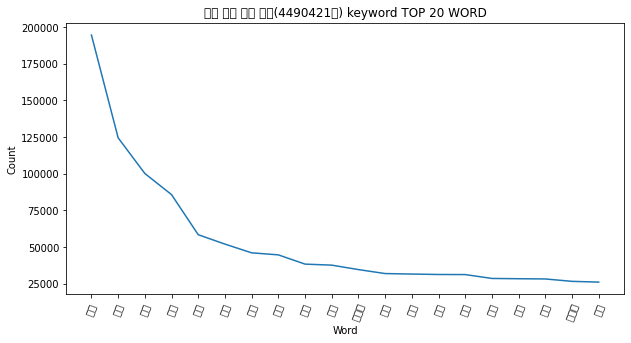

In [ ]:
from matplotlib import rc

results_str = " ".join(dataset) # 결과값 list to string
tokens = results_str.split(" ") # 각 단어별로 떼어 내서
text = nltk.Text(tokens) # text에 저장하고
topWord = text.vocab().most_common(20)
count = 20
xlist = [a[0] for a in topWord[:count]]
ylist = [a[1] for a in topWord[:count]]
plt.figure(0) 

plt.figure(figsize = (10,5)) # 그래프 크기 지정
plt.xlabel('Word') # X축 이름
plt.xticks(rotation=70) # X축 라벨 회전
plt.ylabel('Count') # Y축 이름

result_path = f'사료 전체 후기({len(dataframe)}개) keyword' +' TOP '+str(count)+' WORD'
plt.title(result_path) 
#plt.ylim([0,40]) # y축 범위 (최대값을 기준으로 동일하게 설정하기 위함) 
plt.plot(xlist,ylist) 
plt.savefig('/content/사료카테고리 전체 후기 중 빈도수 상위 20개 단어.png',dpi=150) 

